# Deeperfont
*[Website](http://nbviewer.jupyter.org/github/terryspitz/ipython_notebooks/blob/master/deeperfont.ipynb)*

Deeperfont is a Neural Network attempt at the 'Font Problem' - how to capture the essence of a font in such a way as to generalise to unseen glyphs and to allow interpolation between different fonts.

Initial research suggested the use of [Keras](https://keras.io/) and [Tensorflow](https://www.tensorflow.org/) as best practise for both getting started and long-term research.  

As output the network will generate a set of [glyph outlines](https://en.wikipedia.org/wiki/Glyph).  The encoding of outputs has been considered in two ways: raw (x,y) coordinates, as expressed in the TTF font glyphs, or a conversion of these outlines to (angle, distance) pairs as in [Turtle graphics](https://en.wikipedia.org/wiki/Turtle_graphics) (best known for its  use in [Logo](https://en.wikipedia.org/wiki/Logo_(programming_language).)

Considering the evaluation function we note that the exact sequence of points in the glyph can be varied while generating identical rendered output, for example a line segment can be split into a number of smaller colinear segments.  The network should be free to express its results in any equivalent way.  The evaluation function is therefore required to compare rendered output.  We build an evaluation function in pure Tensorflow using a [scanline algorithm](https://en.wikipedia.org/wiki/Scanline_rendering) to generate a tensor containing the x coordinates of the outline for a set of equi-spaced y line.  The predicted and true outlines are then compared by calculating the difference in these coordinates (or perhaps *visible pixels*).

We need access to the glyph outlines but since the network evaluation function requires the x coordinates we use a final lambda layer to render the outlines for comparison in the loss function, then use the outlines layer from the fitted model when making predictions.

As input we provide the glyph to render, in the form of a [one-hot](https://en.wikipedia.org/wiki/One-hot) vector.

See also:
* [MetaFont](https://en.wikipedia.org/wiki/Metafont)
* [Metaflop - interactive MetaFont](http://www.metaflop.com/modulator)
* [deepfont](https://erikbern.com/2016/01/21/analyzing-50k-fonts-using-deep-neural-networks.html)
* https://arxiv.org/abs/1507.03196
* https://pypi.python.org/pypi/FontTools


In [100]:
import numpy as np
import math
import os
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageChops, ImageFont
from keras.callbacks import TensorBoard
import keras.models as models
import keras.layers as layers
from keras import backend as K
import tensorflow as tf

In [201]:
def renderGlyphs(gls, max_points_per_line, ygrid):
    '''
    Pure tensorflow function
    Input: 2D tensor of glyph * outlines (angle, distance) pairs 
    Output: glyph * matrix of sorted x coords for each line per y coording
    '''
    angles = gls[:,::2]
    dists = gls[:,1::2]
    #turn angles,dists into coordinates
    xs = tf.cumsum(tf.abs(dists)*tf.cos(angles*math.pi), axis=-1)+1e-2
    ys = tf.cumsum(tf.abs(dists)*tf.sin(angles*math.pi), axis=-1)+1e-2
    #offset to create line start x1,y1 to end x2,y2
    x1s = xs[:,:-1]
    x2s = xs[:,1:]
    y1s = ys[:,:-1]
    y2s = ys[:,1:]
    #add 3rd dimension (size=1) so following interpolation in y is broadcast across all lines
    xx1s=tf.expand_dims(x1s,-1)
    xx2s=tf.expand_dims(x2s,-1)
    yy1s=tf.expand_dims(y1s,-1)
    yy2s=tf.expand_dims(y2s,-1)
    #interpolate the x coords for all lines at all y coord
    xxs = xx1s + (xx2s-xx1s)*(ygrid-yy1s)/(yy2s-yy1s)
    #zero x coords outside of line y bounds or where dy=0 and for hidden lines
    in_range = tf.logical_or(tf.logical_and(yy1s<ygrid, ygrid<=yy2s), tf.logical_and(yy2s<ygrid, ygrid<=yy1s))
    in_range = tf.logical_and(in_range, yy2s!=yy1s)
    in_range = tf.logical_and(in_range, tf.expand_dims(dists[:,1:]>0,-1))
    xxs = tf.where(in_range, xxs, tf.zeros_like(xxs)) 
    return tf.nn.top_k(tf.transpose(xxs, perm=(0,2,1)),max_points_per_line).values

In [222]:
def angleDist(p1, p2, unitsPerEm, hidden=False):
    """Given two point tuples return the angle scaled to [-1,1], and distance scaled similarly"""
    dx = p2[0]-p1[0]
    dy = p2[1]-p1[1]
    return math.atan2(dy,dx)/math.pi, math.sqrt(dx**2 + dy**2) * (-1 if hidden else 1) / unitsPerEm  #negative distance means hidden

def generateOutlines(ttx, glyphs, max_points_per_line, ygrid):
    """
    Read the actual points from all glyphs in the font into numpy array.
    Output is array of glyphs x points x 2 (angle in radians, distance).
    We use float according to https://github.com/fchollet/keras/issues/2218.
    """
    unitsPerEm = int(ttx.find('head/unitsPerEm').get('value'))*0.8
    numglyphs = len(glyphs)
    outlines = np.zeros((numglyphs, 200), np.float32)
    Y = np.zeros((numglyphs, len(ygrid),max_points_per_line), np.float32)
    for i, l in enumerate(glyphs):
        glyph = ttx.find(r".//TTGlyph[@name='"+l+"']")
        outline = []
        startp = (0,0)
        #ttx contours are areas within the glyph, like the outside and inside outlines of an O
        for contour in glyph.iterfind('contour'):
            pts = contour.iterfind('pt')
            xy = [(int(pt.get('x')), int(pt.get('y'))) for pt in pts] #should read the ttx 'on' attribute too for bezier control points
            #fill output matrix, start with hidden line to start position
            outline += angleDist(startp, xy[0], unitsPerEm, hidden=True)
            startp = xy[0]
            #then between points
            for n in range(len(xy)-1):
                outline += angleDist(xy[n],xy[n+1], unitsPerEm)
            #finally wrap last point to first in contour
            N=len(xy)-1
            outline += angleDist(xy[N],xy[0], unitsPerEm)
        if len(outline)>outlines.shape[1]: print("outline for "+l+" has too many points: ",len(outline))
        outlines[i,:len(outline)] = np.array(outline[:outlines.shape[1]], dtype=np.float32)
    return outlines

def setupInputOutputRender(ttx, glyphs, outputdim):
    """
    Generate target output by rendering each glyph and reading X coords of the outline.
    Target Output is matrix of x coords of outline for each y coord
    We use float not int according to https://github.com/fchollet/keras/issues/2218.
    """
    numglyphs = len(glyphs)
    Y = np.zeros((numglyphs, outputdim*2), np.float32)
    for i, glyph in enumerate(glyphs):
        im = Image.new('1', size=(cellsize, cellsize), color=(0)) 
        draw = ImageDraw.Draw(im) 
        fnt = ImageFont.truetype('deeper/Quicksand-Bold.otf', cellsize)
        draw.text((10,10), glyph, font=fnt, fill=1)
        im = ImageChops.logical_xor(im,  ImageChops.offset(im, 1, 0))
        print(im.tobytes())
        Y[i] = np.fromstring(im.tobytes())
    
    return Y

def drawOutlines(Y):
    """Draw numpy array interpreted as a glyph per row and each row containing (angle, dist) pairs."""
    cellsize = 100
    columns = math.ceil(800/cellsize)
    rows = math.ceil(Y.shape[0]/columns)
    cellsize = 50
    def drawPoints(im, points):
        #temporary image to use to xor each part with main image
        im2 = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
        draw = ImageDraw.Draw(im2) 
        draw.polygon(points, fill=1)
        im = ImageChops.logical_xor(im, im2)
        return im
    scale = cellsize * 0.8
    im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
    for i in range(Y.shape[0]):
        y,x = divmod(i, columns)
        x *= cellsize
        y = (y+1)*cellsize-1
        points = []
        for j in range(0, Y.shape[1], 2):
            angle = Y[i][j]
            dist = Y[i][j+1]
            x2 = x+ abs(dist)*math.cos(angle*math.pi)*scale
            y2 = y- abs(dist)*math.sin(angle*math.pi)*scale
            if dist>0:
                points += (x2,y2)
            elif len(points)>2:
                im = drawPoints(im, points)
                points=[]
            x=x2
            y=y2
    if len(points)>2:
        im = drawPoints(im, points)
    return im


def drawXYs(xxs, ygrid):
    '''Draw a glyph rasterisation based on a input y coord array with array of x-intercepts of lines with the y coord'''
    cellsize = 100
    columns = math.ceil(800/cellsize)
    rows = math.ceil(xxs.shape[0]/columns)
    scale = cellsize * 0.8
    im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
    draw = ImageDraw.Draw(im) 
    for i in range(xxs.shape[0]):
        yy,xx = divmod(i, columns)
        xx *= cellsize
        yy = (yy+1)*cellsize-1
        for xs, y in zip(xxs[i], ygrid):
            for x in xs:
                if x>0.0:
                    draw.ellipse((xx+x*scale, yy-y*scale, xx+x*scale+3, yy-y*scale+3), fill=1)
    return im

setup...
outline for g has too many points:  204
outline shape:  (62, 200)
output shape:  (62, 20, 6)


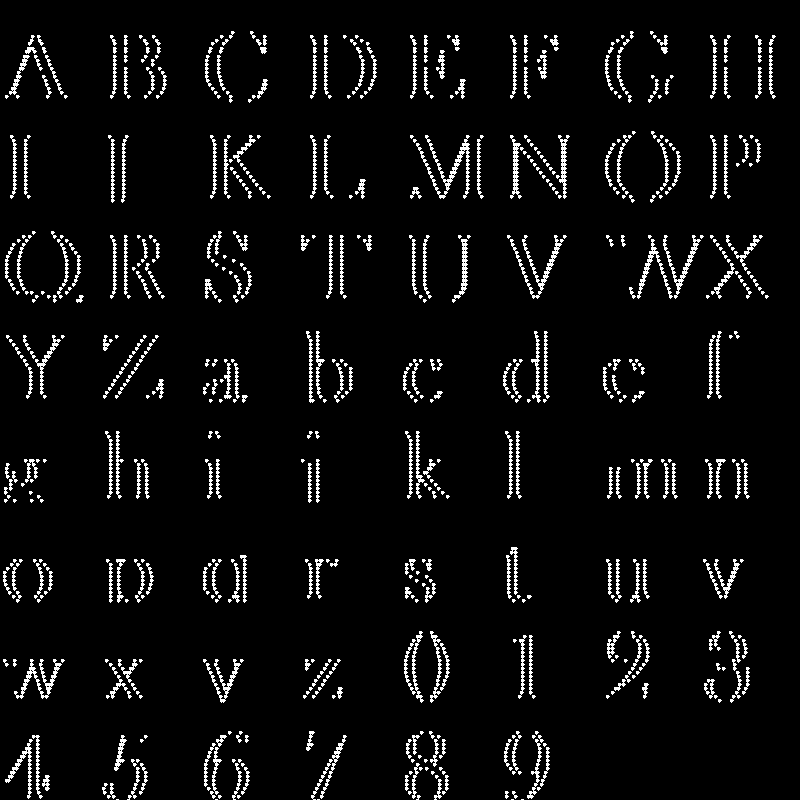

In [227]:
print('setup...')
glyphs = [chr(i) for i in range(ord('A'), ord('Z')+1)]
glyphs += [chr(i) for i in range(ord('a'), ord('z')+1)]
glyphs += ['zero','one','two','three','four','five','six','seven','eight','nine']
#glyphs = ['A','B','a','b','one','two']
np.set_printoptions(precision=2)
ttx = ET.parse(r'deeper/BASKVILL.ttx') #read font data dumped from TrueType using fonttools
max_points_per_line = 6
y_divisions = 20
ygrid = np.linspace(0.0, 1.0, y_divisions, endpoint=False) #y coordinates to render on
X = np.identity(len(glyphs), dtype=float)  #input is 'one-hot' array, one per glyph
outlines = generateOutlines(ttx, glyphs, max_points_per_line, ygrid)
print("outline shape: ",outlines.shape)
with tf.Session() as sess:
    Y_true = renderGlyphs(outlines, max_points_per_line, ygrid).eval()
    #print(Y_true)
    print("output shape: ", Y_true.shape)
drawXYs(Y_true, ygrid)
#drawOutlines(outlines)

In [229]:
#update modelNum to refit, uses saved model if found
modelNum = 11
file = "deepermodel"+str(modelNum)+".h5"
if False: #os.path.isfile(file):
    model = keras.models.load_model(file)
    print("loaded model")
else:
    print('compile model...')
    model = Sequential()
    model.add(layers.Dense(100, input_dim=X.shape[1]))
    #model.add(LSTM(4))#, return_sequences=True))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(200, name='outlines'))
    model.add(layers.Lambda(lambda outline:renderGlyphs(outline, max_points_per_line, ygrid), name='renderGlyph'))
    print(model.output_shape)
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

    print('fitting model...')
    epochs=100
    logs = 'logs/run'+str(modelNum)
    print('tensorboard --logdir='+os.path.abspath('logs'))
    board = TensorBoard(log_dir=logs, histogram_freq=10000)
    model.fit(X, Y_true, batch_size=len(glyphs), epochs=epochs, verbose=0, callbacks=[board])
    scores = model.evaluate(X, Y_true, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    model.save(file)
    print('saved: '+file)

compile model...
compile model...
(None, 20, 6)
fitting model...
tensorboard --logdir=C:\src\Repos\ipython_notebooks\logs
loss: 8.72%
mean_absolute_error: 16.39%
saved: deepermodel11.h5


In [230]:
print('predict outlines...')
outlines_model = models.Model(inputs=model.input, outputs=model.get_layer('outlines').output)
outlines_new = outlines_model.predict(X, verbose=0)
drawOutlines(outlines_new)
print("outlines: ",outlines)
print("outlines_new: ",outlines_new)
xcoords_new = model.predict(X, verbose=1)
print("xcoords: ",outlines)
print("outlines: ",outlines_new)
#drawXYs(xcoords,ygrid)

predict outlines...
outlines:  [[ 0.   -0.88  1.   ...,  0.    0.    0.  ]
 [ 0.   -0.03  0.5  ...,  0.    0.    0.  ]
 [ 0.26 -1.14 -0.49 ...,  0.    0.    0.  ]
 ..., 
 [ 0.31 -0.99 -0.62 ...,  0.    0.    0.  ]
 [ 0.28 -0.59 -0.16 ...,  0.    0.    0.  ]
 [ 0.21 -0.58 -0.78 ...,  0.    0.    0.  ]]
outlines:  [[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]


6/6 [==============================] - 0s


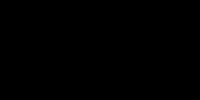

In [213]:
#now, what happens when we predict mixed glyphs?
mixed_outlines = outlines_model.predict(np.random.random(X.shape), verbose=1)
drawOutlines(mixed_outlines)

13/13 [==============================] - 0s


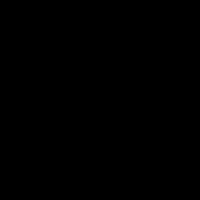

In [214]:
#what about interpolating between glyphs?  let's try gradually mixing A into B
#need array [[1, 0, ...], [1, 0.1, ...]]
A = X[0]
B = X[1]
steps=12
mix = np.array([A*(steps-i)/steps + i*B/steps for i in range(steps+1)])
#print(mix[:3])
interp = outlines_model.predict(mix, verbose=1)
drawOutlines(interp)
#not very convincing :(, perhaps raw points rather than angle, dist pairs for the outline would be better
#also need to try interpolating A between two fonts